In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import modeling_tools as mt
import murmurhash as mhash

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances

In [2]:
labeled_data = pd.read_pickle('../data/labeled_data_pos_ont_nn.pkl')
drop_trash = (labeled_data['Aggr.Label'] < 90) & (labeled_data['NN_bool'] == False)
labeled_data = labeled_data[drop_trash]

In [3]:
pos_features = ['Adjective', 'Verb', 'Noun']
ont_features = ['Underspecified', 'Artifact', 'Object', 'Group', 'Human', 'Natural', 'LanguageRepresentation', 'Living', 'GeopoliticalPlace', 'BodyPart', 'Instrument', 'Place', '3rdOrderEntity', 'Mental', 'Purpose', 'Social', 'Institution', 'Plant', 'Imagerepresentation', 'Creature', 'Animal', 'Comestible', 'Quantity', 'Building', 'Substance', 'Part', 'Property', 'BoundedEvent', 'Agentive', 'Communication', 'Garment', 'Furniture', 'Vehicle', '1stOrderEntity', 'Covering', 'Liquid', 'Time', 'UnboundedEvent', 'Physical', 'Dynamic', 'Domain', 'Existence', 'Location', 'Manner', 'Container', 'Condition', 'Static', '2ndOrderEntity', 'Phenomenal', 'MoneyRepresentation', 'Experience', 'Relation', 'Form', 'Representation', 'Stimulating', 'Colour', 'Cause', 'Occupation', 'Possession', 'Artwork', 'Software']
numerical_features = ['Raw_len', 'Raw_word_count']
categorical_features = ['Label', 'Aggr.Label', 'Source', 'CoderId']
text_features = ['Lemma_stripped', 'Raw', 'Lemma']
fastt_features = ['Raw_FT_mean', 'Lemma_FT_mean']
features = pos_features + ont_features + numerical_features + text_features + fastt_features + categorical_features

fastt = 'Raw_FT_mean'
corpus = 'Lemma'
target = 'Aggr.Label'
#target = 'Label'


train_X, validation_X, train_y, validation_y = train_test_split(
    labeled_data[features],
    labeled_data[target],
    test_size=0.33,
    random_state=1,
    stratify=labeled_data[target])

In [4]:
number_labels = labeled_data[target].unique().shape[0]
len_columns = labeled_data.shape[0]
num_classifiers = 4
num_buckets = round(number_labels/num_classifiers)

In [5]:
class BucketClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, hashfunc, classifiers, judge):
        self.num_classifiers = len(classifiers)
        self.hashfunc = hashfunc
        self.classifiers = classifiers
        self.judge = judge
 
    def fit(self, X, y):

        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        
        #self.num_buckets = round(len(self.classes_)/self.num_classifiers)
        #self.num_buckets = round(len(self.classes_)/5)
        self.num_buckets = 10
        self.buckets = [[] for _ in range(self.num_buckets)]

        bucketed = []

        for n in range(self.num_classifiers):
            bucketed.append([self.hashfunc.hash(str(yi+n))%self.num_buckets for yi in self.y_])
            for yu in self.classes_:
                b = self.hashfunc.hash(str(yu+n))%self.num_buckets
                self.buckets[b].append(yu)

        self.bucketed_ = bucketed
        
        self.bucketed_t_ = np.array(bucketed).T

        for ci in range(self.num_classifiers):
            self.classifiers[ci].fit(self.X_, self.bucketed_[ci])

            
        self.judge.fit(self.bucketed_t_, self.y_)

        return self

    def predict(self, X):

        bucket_preds = []
        
        for ci in range(self.num_classifiers):
            bucket_preds.append(self.classifiers[ci].predict(X))
        
        bucket_preds_t = np.array(bucket_preds).T
        
        '''
        preds = []

        for p in range(X.shape[0]):
            candidates = {}
            for b in bucket_preds_t[p]:
                for yu in self.buckets[b]:
                    if yu not in candidates:
                        candidates[yu] = 1
                    else:
                        candidates[yu] += 1
            sorted_candidates = sorted(candidates.items(), key=lambda kv: kv[1], reverse=True)
            preds.append(sorted_candidates[0])
            
            
        return [x for x,_ in preds]
        '''
        
        preds = self.judge.predict(bucket_preds_t)

        return preds

In [6]:
vectorizer = TfidfVectorizer(**{'max_df': 0.3, 'max_features': None, 'norm': 'l2', 'strip_accents': 'ascii', 'use_idf': False})
train_x = vectorizer.fit_transform(train_X[corpus])
validation_x = vectorizer.transform(validation_X[corpus])

In [7]:
classifiers = [MultinomialNB(alpha=0.001) for _ in range(10)]
clf = BucketClassifier(mhash, classifiers, MultinomialNB(alpha=0.001))

clf.fit(train_x, train_y)
preds = clf.predict(validation_x)
np.mean(preds == validation_y)

0.42605489553461695

(24, 24)


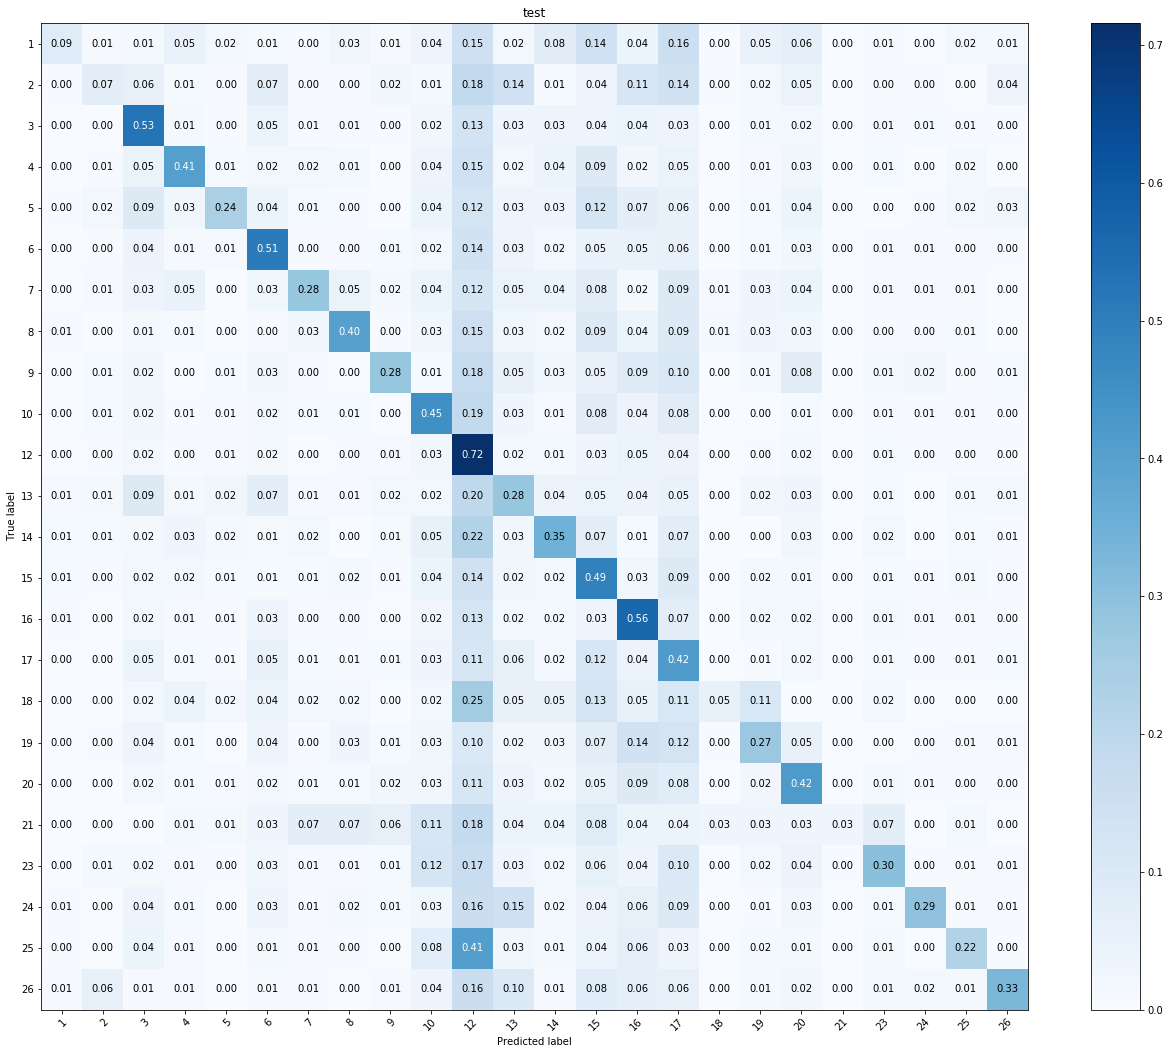

In [8]:
testy = mt.plot_cf(validation_y, preds, title = 'test')